In [138]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [139]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [140]:
#filling missing values
train["Age"] = train["Age"].fillna(30)
train["Embarked"].fillna("S", inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [141]:
#transform non-numerical labels to numerical labels
encoder = LabelEncoder()
for col in ('Sex','Embarked'):
    train['Sex'] = encoder.fit_transform(train['Sex'])
    train['Embarked'] = encoder.fit_transform(train['Embarked'])

In [142]:
#Features
train_x = train.drop(["PassengerId","Name","Ticket","Cabin","Survived"], axis=1)
#label
train_y = train["Survived"]
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    int64  
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


In [143]:
#Choose only the data that contains survivors
survived_label = train.groupby(['Survived'])
alive = survived_label.get_group(1)

In [144]:
#Choose only the data that contains dead people
dead = survived_label.get_group(0)

In [145]:
#ALIVE
#FEATURES
alive_x = alive.drop(["PassengerId","Name","Ticket","Cabin","Survived"], axis=1)
#label
alive_y = alive["Survived"]
alive_x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
1,1,0,38.0,1,0,71.2833,0
2,3,0,26.0,0,0,7.9250,2
3,1,0,35.0,1,0,53.1000,2
8,3,0,27.0,0,2,11.1333,2
9,2,0,14.0,1,0,30.0708,0


In [146]:
#DEAD
#FEATURES
dead_x = dead.drop(["PassengerId","Name","Ticket","Cabin","Survived"], axis=1)
#label
dead_y = dead["Survived"]
dead_x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.0,1,0,7.2500,2
4,3,1,35.0,0,0,8.0500,2
5,3,1,30.0,0,0,8.4583,1
6,1,1,54.0,0,0,51.8625,2
7,3,1,2.0,3,1,21.0750,2


In [147]:
#Sampling the data 80% train 20% test
#GENERAL
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, 
                                                  test_size=0.2, 
                                                  random_state=1)

#ALIVE
train_alive_x, test_alive_x, train_alive_y, test_alive_y = train_test_split(alive_x, alive_y, 
                                                  test_size=0.2, 
                                                  random_state=1)
#DEAD
train_dead_x, test_dead_x, train_dead_y, test_dead_y = train_test_split(dead_x, dead_y, 
                                                  test_size=0.2, 
                                                  random_state=1)

**Python API**

We need to convert the data into DMatrix. This is only necessary for the bare python api. The Following 4 (four) cells are an attempt to use this method. Unfortunately, as we will see, problems will arise. We will end up using the scikit-learn api.

In [148]:
#Converting to DMatrix
#GENERAL
d_train = xgb.DMatrix(train_x, train_y)
d_test = xgb.DMatrix(test_x, test_y)
#ALIVE
d_train_alive = xgb.DMatrix(train_alive_x, train_alive_y)
d_test_alive = xgb.DMatrix(test_alive_x, test_alive_y)
#DEAD
d_train_dead = xgb.DMatrix(train_dead_x, train_dead_y)
d_test_dead = xgb.DMatrix(test_dead_x, test_dead_y)

In [149]:
param = {
    'booster':'gbtree',
    'eta':0.3, #prevents overfitting
    'max_depth':3, #maximum depth of tree
    'objective':'binary:hinge',
    'rate_drop':0.1,
    'n_estimators':500
}

steṕs = 20

In [150]:
model = xgb.train(param, d_train, steṕs)

[12:27:03] WARNING: /workspace/src/learner.cc:480: 
Parameters: { n_estimators, rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [151]:
#predictions alive
predictions = model.predict(d_test_alive)
#print accuracy
print(np.round(accuracy_score(test_alive_y,predictions)*100, 2),'%')

76.81 %


I couldn't figure out how to obtain the probabilities. I tried to use the code we implemented in tensorflow but i kept getting an error.

Below, I use the XGB scikt-learn api. It seems to work well!

**XGB Classifier (scikit-learn API)**

In [152]:
#XGBClassifier scikit-learn API 
model = xgb.XGBClassifier(objective = 'binary:logistic', max_depth = 6, learning_rate=0.3)
#fit = training
model.fit(train_x, train_y)
#predictions
predict_alive = model.predict(test_alive_x)
print(np.round(accuracy_score(test_alive_y,predict_alive)*100, 2),'%')
print('\nPredictions', predict_alive)

88.41 %

Predictions [0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1]


In [153]:
predict_prob = model.predict_proba(test_alive_x)

In [154]:
#converting prob values to list
df_prob = pd.DataFrame(predict_prob)
s_prob_alive = df_prob[df_prob.columns[1]] 
list_prob_alive = s_prob_alive.values.tolist()

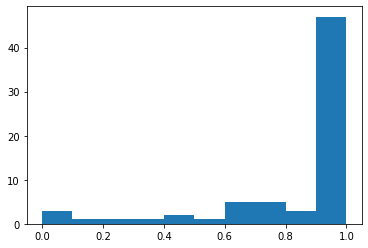

In [155]:
hist_alive = plt.hist(list_prob_alive, range=(0,1))

In [156]:
#converting prob values to list
predict_dead = model.predict(test_dead_x)
predict_prob_dead = model.predict_proba(test_dead_x)
df_prob_dead = pd.DataFrame(predict_prob_dead)
s_prob_dead = df_prob_dead[df_prob_dead.columns[1]] 
list_prob_dead = s_prob_dead.values.tolist()

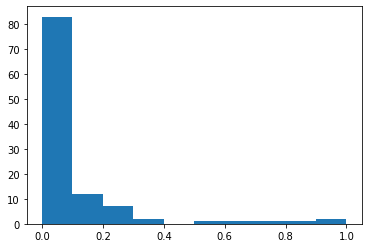

In [157]:
hist_dead = plt.hist(list_prob_dead, range=(0,1))

Text(0.5, 1.0, 'Results using XGB')

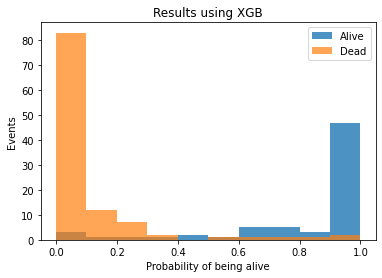

In [158]:
plt.hist(list_prob_alive, range=(0,1), alpha=0.8,label='Alive')
plt.hist(list_prob_dead, range=(0,1), alpha=0.7, label='Dead')
plt.legend(loc='upper right')
plt.xlabel('Probability of being alive')
plt.ylabel('Events')
plt.title('Results using XGB')

**ROC Curve**

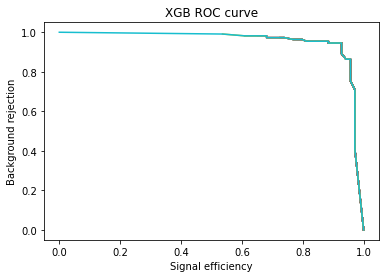

In [159]:
#CREEMOS DATOS ALEADORIOS Y ORDENEMOLOS DE MENOR A MAYOR

list_prob_alive = sorted(list_prob_alive)
list_prob_dead = sorted(list_prob_dead)

#LISTAS DONDE SE GUARDARAN LOS VALORES DE EFICIENCIA Y BACK_REJECTION
eficiency = []
background_rejection = []

#ITERAMOS SOBRE UN FLOAT QUE VA DE 0 A 100 EN 1000 PASOS
for cut in np.linspace(0,1, 50):
    
    #INICIALIZAMOS EL VALOR DE VIVOS ACEPTADOS Y MUERTOS RECHAZADOS
    #PUES EN EL CORTE = 0 ACEPTAMOS TODOS LOS 1s Y RECHAZAMOS TODOS LOS 0s
    vivos_aceptados = len(list_prob_alive)
    muertos_rechazados = 0


    for i, v in enumerate(list_prob_alive):
        # YA QUE LAS LISTAS ESTAN ORDENADAS BASTA CON CHECAR EL PRIMER VALOR QUE 
        # SEA MAYOR QUE EL CORTE
        if cut<=v:
            vivos_aceptados-=i
            break
        #EN EL CASO DE QUE EL CORTE SEA MAYOR QUE TODAS LAS PROBS CONSIDERA QUE 
        # NINGUN VIVO FUE ACEPTADO
        if i==len(list_prob_alive)-1:
            vivos_aceptados=0

    # ANALOGAMENTE PARA LOS MUERTOS        
    for i, m in enumerate(list_prob_dead):
        if cut<=m:
            muertos_rechazados+=i
            break
        if i==len(list_prob_dead)-1:
            muertos_rechazados=len(list_prob_dead)
    
    #ALMACENA EN LA LISTA
    eficiency.append(vivos_aceptados/len(list_prob_alive))
    background_rejection.append(muertos_rechazados/len(list_prob_dead))

    neural = plt.plot(eficiency, background_rejection)
    plt.xlabel('Signal efficiency')
    plt.ylabel('Background rejection')
    plt.title('XGB ROC curve')